In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dlomix.interface import load_keras_model, process_dataset
from dlomix.losses import masked_spectral_distance

2024-08-13 10:58:54.009890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 10:58:54.009932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 10:58:54.011608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 10:58:54.020612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 10:58:55.760765: W tensorflow/compiler/tf2


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [ ]:
from oktoberfest.runner import run_job
runner = run_job('./configs/large_etd_holdout_config.json')

In [4]:
refined_model = load_keras_model('/cmnfs/proj/bmpc_dlomix/oktoberfest_output/refinement_etd_out/data/dlomix/refined.keras')
scratch_model = load_keras_model('/cmnfs/proj/bmpc_dlomix/models/refinement_transfer_learning/etd_models/ETD_from_scratch/etd_from_scratch.keras')

2024-08-12 15:57:00.293742: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-12 15:57:00.293788: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dragon.exbio.wzw.tum.de
2024-08-12 15:57:00.293797: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dragon.exbio.wzw.tum.de
2024-08-12 15:57:00.293908: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-08-12 15:57:00.293941: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-08-12 15:57:00.293948: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [5]:
dataset = process_dataset(
    parquet_file_path='./rescoring_out_large/data/dlomix/refinement_dataset/processed_dataset.parquet',
    model=refined_model,
    ion_types=['z', 'c'],
    val_ratio=0.1,
    test_ratio=0.3
)


                Number of ions is the same as the loaded model supports, but the ion types are different.
                The model probably needs to be refined to achieve a better performance on these new ion types.
                


Generating train split: 0 examples [00:00, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/26038 [00:00<?, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/4340 [00:00<?, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/13019 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/26038 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/4340 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/13019 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/26038 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/4340 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/13019 [00:00<?, ? examples/s]

Filter:   0%|          | 0/26038 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4340 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26038 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4340 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/13019 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 26038
    })
    val: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 4340
    })
    test: Dataset({
        features: ['modified_sequence', 'intensities_raw', 'precursor_charge_onehot', 'collision_energy_aligned_normed', 'method_nbr', '_parsed_sequence', '_n_term_mods', '_c_term_mods'],
        num_rows: 13019
    })
})

In [7]:
sd_refined = list()
for batch, y_true in dataset.tensor_test_data:
    y_pred = refined_model.predict(batch)
    sd_refined.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

23/23 [==============================] - 3s 83ms/step


In [8]:
sd_scratch = list()
for batch, y_true in dataset.tensor_test_data:
    y_pred = scratch_model.predict(batch)
    sd_scratch.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

23/23 [==============================] - 3s 87ms/step


Text(0.5, 0, 'Spectral Angle')

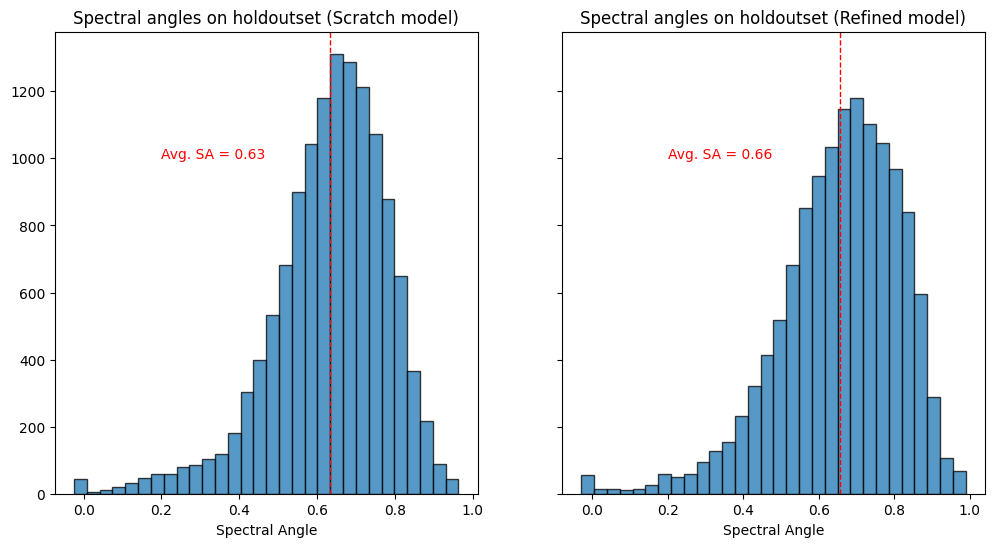

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sa_scratch = [1 - sd for sd in sd_scratch]
avg_sa_scratch = np.mean(sa_scratch)
ax[0].hist(sa_scratch, bins=30, alpha=0.75, edgecolor='black')
ax[0].axvline(avg_sa_scratch, color='r', linestyle='dashed', linewidth=1)
ax[0].text(0.2, 1e3, f'Avg. SA = {avg_sa_scratch:.2f}', color='r')
ax[0].set_title(f'Spectral angles on holdoutset (Scratch model)')
ax[0].set_xlabel('Spectral Angle')

sa_refined = [1 - sd for sd in sd_refined]
avg_sa_refined = np.mean(sa_refined)
ax[1].hist(sa_refined, bins=30, alpha=0.75, edgecolor='black')
ax[1].axvline(avg_sa_refined, color='r', linestyle='dashed', linewidth=1)
ax[1].text(0.2, 1e3, f'Avg. SA = {avg_sa_refined:.2f}', color='r')
ax[1].set_title(f'Spectral angles on holdoutset (Refined model)')
ax[1].set_xlabel('Spectral Angle')